In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
from collections import Counter

https://www.kaggle.com/jirakst/homecredit-an-approach

In [2]:
data_application = pd.read_csv("csv/application_train.csv")
data_application_test = pd.read_csv("csv/application_test.csv")


In [3]:
print("data_application : ", data_application.shape)
print("data_application_test : ", data_application_test.shape)


data_application :  (307511, 122)
data_application_test :  (48744, 121)
data_bureau :  (1716428, 17)
data_bureau_balance :  (27299925, 3)
data_credit_card_balance :  (3840312, 23)
data_installments_payments :  (13605401, 8)
data_previous_application :  (1670214, 37)


Valeurs abbérantes

Regardons la variable days_employed

In [20]:
data_application["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Le nombre maximal de jours travaillés est de 1000 ans ce qui est impossible

In [21]:
data_application[data_application['DAYS_EMPLOYED'] == 365243].shape


(55374, 122)

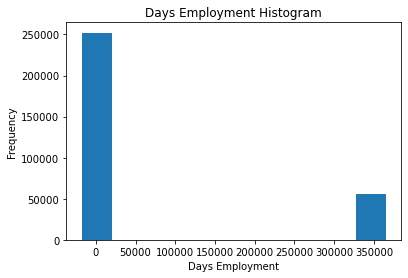

In [22]:
data_application['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Il y a plus de 55374 lignes ayant un nombre de jours travaillés de 365243. Nous allons modifier ces données et les remplir
avec la valeur np.nan

In [23]:
data_application['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

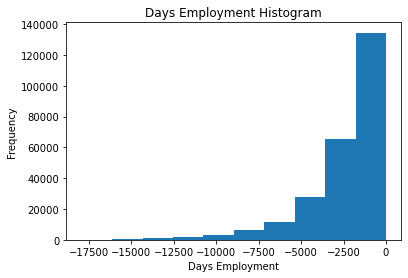

In [24]:
plt.figure(figsize=(6,4))
data_application['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [39]:
def detect_outliers(df,n,features):
    '''
    En entrée :
    df : dataframe
    n : nb d'outliers
    features : liste de features
    En sortie
    multiple_outliers : observations avec plus de n outliers
    '''
    
    outlier_indices = []
    
    for col in features:
        Q1 = df[col].quantile(0.02)
        Q3 = df[col].quantile(0.98)
        IQR = Q3 - Q1
        
        outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR )].index
        outlier_indices.extend(outliers)
        
    # Select observations with more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [40]:
# Return only float64 features
numerical_feature_mask = data_application.dtypes == float
numerical_cols = data_application.columns[numerical_feature_mask].tolist()

In [43]:
# Detect outliers
Outliers_to_drop = detect_outliers(data_application, 2, numerical_cols)

In [44]:
# Number of outliers to drop
len(Outliers_to_drop)

2454

C'est un nombre acceptable

In [45]:
# Remove outliers
data_application.drop(Outliers_to_drop, inplace=True)

# Concaténation des données

In [46]:
# Save Id for the submission at the very end.
Id = data_application_test['SK_ID_CURR']

In [47]:
# Get marker
split = len(data_application)

In [51]:
# Merge into one dataset
data =  pd.concat(objs = [data_application, data_application_test], axis = 0).reset_index(drop = True)

In [52]:
# We don't need the Id anymore now.
data.drop('SK_ID_CURR', axis = 1, inplace = True)

In [53]:
data.shape

(353801, 121)

Gestion des valeurs nulles

In [55]:
# Remove mostly sparse features
for f in data:
    if data[f].isnull().sum() / data.shape[0] >= 0.5:
        del data[f] # Or do a boolean flag here

In [56]:
# Check for TARGET data type
data['TARGET'].dtype

dtype('float64')

In [57]:
# Select columns due to theirs data type
float_col = data.select_dtypes('float').drop(['TARGET'], axis=1)
int_col = data.select_dtypes('int')
object_col = data.select_dtypes('object')

In [58]:
# Remove and impute numerical features
for f in float_col:
    if data[f].isnull().sum() / data.shape[0] > 0.1667: 
        del data[f] # Remove 1/6+ of NANs
    else: 
        data[f] = data[f].fillna(data[f].mean()) # Impute others with a mean value

In [59]:
# Impute default value into a numerical category
for i in int_col:
    data[i] = data[i].fillna(-1)

In [60]:
# Impute object type with a default
for o in object_col:
    data[o] = data[o].fillna('Unknown')

In [61]:
# Check
data.isnull().sum().sort_values(ascending=False).head(5)

TARGET                48744
NAME_CONTRACT_TYPE        0
FLAG_DOCUMENT_8           0
FLAG_DOCUMENT_7           0
FLAG_DOCUMENT_6           0
dtype: int64

Seul le target dans le dataset peut-être rempli de valeurs nan

Encodage des données

In [62]:
data = pd.get_dummies(data, prefix_sep='_', drop_first=True) # Drop originall feature to avoid multi-collinearity

Standardisation des données

Dans le but d'utiliser une analyse en composantes principales, nous allons standardiser nos données

In [63]:
#Split data
train_c = data[:split]
test_c = data[split:].drop(['TARGET'], axis=1)

In [64]:
from sklearn.model_selection import train_test_split

# Get variables for a model
x = train_c.drop(["TARGET"], axis = 1)
y = train_c["TARGET"]

#Do train data splitting
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.22, random_state = 101)

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) # Fit on training set only.

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [67]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Model

In [68]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'lbfgs').fit(X_train, y_train)
pred = lr.predict(X_test)
acc = lr.score(X_test, y_test)

print("Accuracy: ", acc)

Accuracy:  0.9190767809515296


C:\Users\Jo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Model Evaluation

## Matrice de confusion

In [70]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predicts = cross_val_predict(lr, X_train, y_train, cv=3)
confusion_matrix(y_train, predicts)

C:\Users\Jo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Jo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Jo\anaconda3\lib\site-packages\sklearn\

array([[218718,     17],
       [ 19191,     18]], dtype=int64)

Dans la première ligne, 218718 clients ont été correctement prédits comme n'ayant pas de difficultés de paiement (vrais négatifs) et 17 ont été classés à tort comme n'ayant pas de difficultés de paiement (faux négatifs). Au deuxième rang, 19 192 clients ont été classés à tort en difficulté de paiement (faux positif) et 17 d'entre eux ont été correctement classés en difficulté de paiement (vrai négatif)

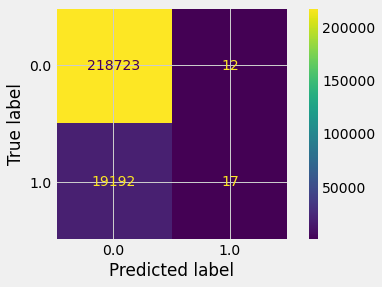

In [73]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_train, y_train) 

## Precision and Recall

In [77]:
from sklearn.metrics import precision_score, recall_score, classification_report

print("Precision:", precision_score(y_train, predicts))
print("Recall:",recall_score(y_train, predicts))

Precision: 0.5142857142857142
Recall: 0.0009370607527721381


La précison nous donne la probabilité qu'à un client d'être classé correctement.

In [78]:
print(classification_report(y_train, predicts))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    218735
         1.0       0.51      0.00      0.00     19209

    accuracy                           0.92    237944
   macro avg       0.72      0.50      0.48    237944
weighted avg       0.89      0.92      0.88    237944



## F1-score

In [79]:
from sklearn.metrics import f1_score

f1_score(y_train, predicts)

0.0018707129494907506

Le score F1 est calculé comme la moyenne harmonique de la précision et du rappel, ainsi un score F1 élevé n'est possible que si la précession et le rappel sont élevés

## Courbe de précision du recall

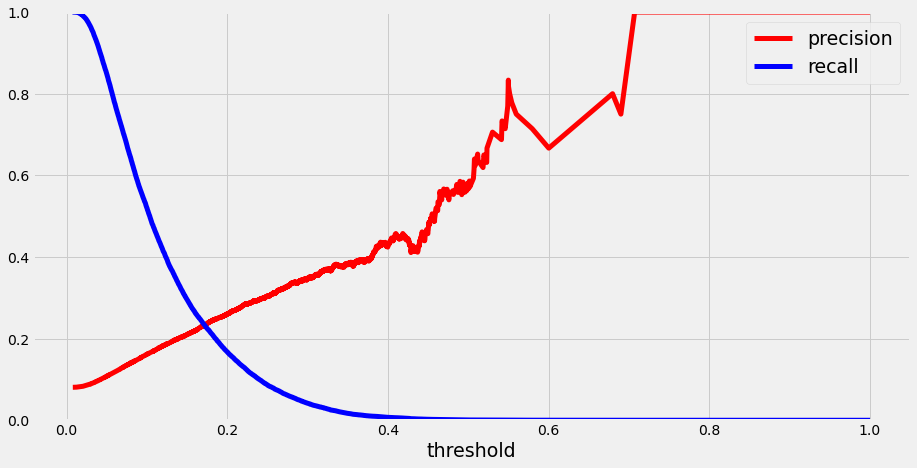

In [80]:
from sklearn.metrics import precision_recall_curve

y_scores = lr.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Sur la base de la chute rapide de la courbe de rappel, il est possible de définir un compromis rappel/précision avant.

## Courbe de ROC

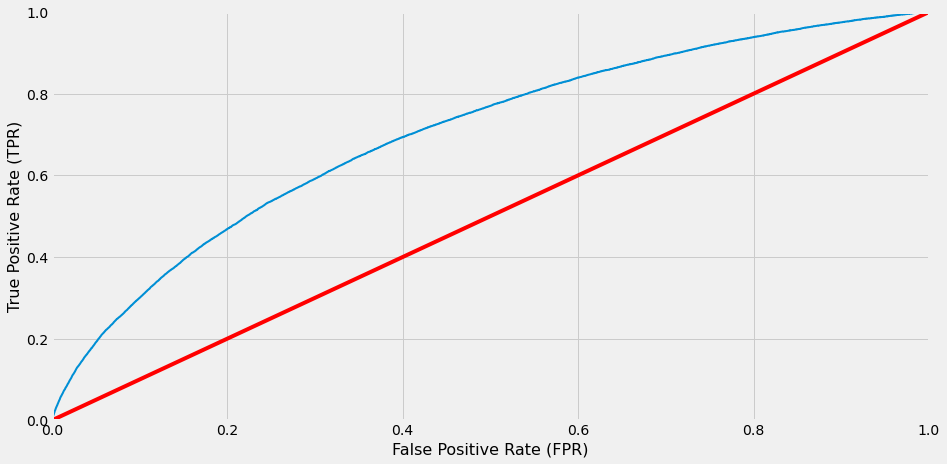

In [81]:
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Plus la courbe bleue penche vers le coin supérieur gauche (angle droit), mieux un modèle prédit les résultats réels.

## ROC Score

In [82]:
from sklearn.metrics import roc_auc_score

In [83]:
y_scores = lr.predict_proba(X_train)
y_scores = y_scores[:, 1]

In [84]:
auroc = roc_auc_score(y_train, y_scores)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.7017445439507781
